In [1]:
%%time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
#import tensorflow.keras.utils.to_categorical
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
%matplotlib inline
import keras
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LeakyReLU
from emnist import extract_training_samples
from emnist import extract_test_samples
from tensorflow.keras import utils
from matplotlib import pyplot
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import time
import os
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


CPU times: user 2.36 s, sys: 1.39 s, total: 3.76 s
Wall time: 32.2 s


In [2]:
#Global para's

img_width, img_height = 28, 28
leaky_relu_alpha = 0.1

In [3]:
X_train, y_train = extract_training_samples('balanced')
X_test, y_test = extract_test_samples('balanced')

num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], num_pixels)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], num_pixels)).astype('float32')

X_train = X_train / 255
X_test = X_test / 255

y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
num_classes = y_test.shape[1]


'''
CNN's require a different formal of input data as compared to MLP;
this function reshapes the image data accordingly.

Reshapring for 3D cnn format since we are using black and white images, gotta made it 3dim.

'''

img_width, img_height = 28, 28

X_trainCNN, y_trainCNN = extract_training_samples('balanced')
X_testCNN, y_testCNN = extract_test_samples('balanced')

if K.image_data_format() == 'channels_first':
    X_trainCNN = X_trainCNN.reshape(X_trainCNN.shape[0], 1, img_width, img_height)
    X_testCNN = X_testCNN.reshape(X_testCNN.shape[0], 1, img_width, img_height)
    CNNinput_shape = (1, img_width, img_height)
else:
    X_trainCNN = X_trainCNN.reshape(X_trainCNN.shape[0], img_width, img_height, 1)
    X_testCNN = X_testCNN.reshape(X_testCNN.shape[0], img_width, img_height, 1)
    CNNinput_shape = (img_width, img_height, 1)
    
X_trainCNN = X_trainCNN / 255
X_testCNN = X_testCNN / 255
    
y_trainCNN = utils.to_categorical(y_trainCNN)
y_testCNN = utils.to_categorical(y_testCNN)

In [4]:
'''
Image rotation of 40 degree's (minics difference angles of writing)
Shear, Vertical, Horizontal shifts by 0.08 (minic displacements and cursive fonts)
Zoom's in by 0.08 (minics alphabets size difference)

'''

img_gen = ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False,  
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=40,
    #shear_range = 30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #zoom_range = [-0.5,0.5],
    horizontal_flip=False)

In [5]:

def conv_model():

    '''
    {784 - [32C3-32C3-32C5S2] - [64C3-64C3-64C5S2] - 128 - 47}
    '''
    
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size = 3,input_shape = CNNinput_shape))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size = 3))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))    
    model.add(BatchNormalization())

    model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))    
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    
    
    model.add(Conv2D(64, kernel_size = 3))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, kernel_size = 3))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
        
    model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    

    model.add(Conv2D(128, kernel_size = 4))
    model.add(LeakyReLU(alpha=leaky_relu_alpha))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.5))
               
    model.add(Dense(num_classes, activation='softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [6]:
CNN_model = conv_model()

In [7]:
%%time

#Aug train only

CNNHistory = CNN_model.fit(img_gen.flow(X_trainCNN,y_trainCNN), validation_data=(X_testCNN, y_testCNN), batch_size=100,epochs=75, verbose=2)
CNN_scores = CNN_model.evaluate(X_testCNN, y_testCNN, verbose=2)

print("Baseline Error: %.2f%%" % (100-CNN_scores[1]*100))
print(f'Test loss for base CNN: {CNN_scores[0]} / Test accuracy: {CNN_scores[1]}')

Epoch 1/75
3525/3525 - 150s - loss: 1.6339 - accuracy: 0.5259 - val_loss: 0.5260 - val_accuracy: 0.8223
Epoch 2/75
3525/3525 - 151s - loss: 0.9097 - accuracy: 0.7070 - val_loss: 0.4741 - val_accuracy: 0.8386
Epoch 3/75
3525/3525 - 146s - loss: 0.7817 - accuracy: 0.7446 - val_loss: 0.4603 - val_accuracy: 0.8441
Epoch 4/75
3525/3525 - 147s - loss: 0.7253 - accuracy: 0.7615 - val_loss: 0.4215 - val_accuracy: 0.8566
Epoch 5/75
3525/3525 - 146s - loss: 0.6829 - accuracy: 0.7746 - val_loss: 0.4004 - val_accuracy: 0.8627
Epoch 6/75
3525/3525 - 145s - loss: 0.6615 - accuracy: 0.7807 - val_loss: 0.4110 - val_accuracy: 0.8589
Epoch 7/75
3525/3525 - 143s - loss: 0.6325 - accuracy: 0.7895 - val_loss: 0.3800 - val_accuracy: 0.8667
Epoch 8/75
3525/3525 - 141s - loss: 0.6210 - accuracy: 0.7920 - val_loss: 0.3968 - val_accuracy: 0.8623
Epoch 9/75
3525/3525 - 134s - loss: 0.6058 - accuracy: 0.7966 - val_loss: 0.3765 - val_accuracy: 0.8679
Epoch 10/75
3525/3525 - 134s - loss: 0.5925 - accuracy: 0.8009 -

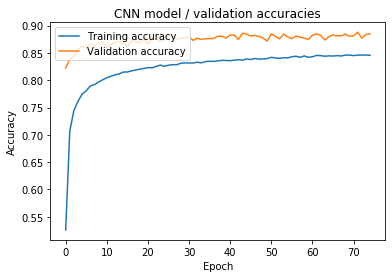

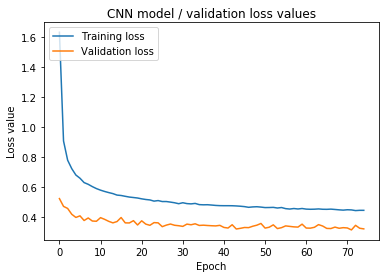

In [8]:
plt.plot(CNNHistory.history['accuracy'], label='Training accuracy')
plt.plot(CNNHistory.history['val_accuracy'], label='Validation accuracy')
plt.title('CNN model / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(CNNHistory.history['loss'], label='Training loss')
plt.plot(CNNHistory.history['val_loss'], label='Validation loss')
plt.title('CNN model / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [9]:
CNN_model2 = conv_model()

In [10]:
%%time

#Aug test only

CNNHistory2 = CNN_model2.fit(X_trainCNN,y_trainCNN, validation_data=(X_testCNN, y_testCNN), batch_size=200,epochs=50, verbose=2)
CNN_scores2 = CNN_model2.evaluate(img_gen.flow(X_testCNN, y_testCNN), verbose=0)

print("Baseline Error: %.2f%%" % (100-CNN_scores2[1]*100))
print(f'Test loss for base CNN: {CNN_scores2[0]} / Test accuracy: {CNN_scores2[1]}')

Epoch 1/50
564/564 - 55s - loss: 1.2217 - accuracy: 0.6492 - val_loss: 0.5544 - val_accuracy: 0.8161
Epoch 2/50
564/564 - 55s - loss: 0.5659 - accuracy: 0.8113 - val_loss: 0.4048 - val_accuracy: 0.8602
Epoch 3/50
564/564 - 55s - loss: 0.4750 - accuracy: 0.8375 - val_loss: 0.3917 - val_accuracy: 0.8647
Epoch 4/50
564/564 - 55s - loss: 0.4403 - accuracy: 0.8482 - val_loss: 0.3682 - val_accuracy: 0.8716
Epoch 5/50
564/564 - 55s - loss: 0.4183 - accuracy: 0.8540 - val_loss: 0.3673 - val_accuracy: 0.8741
Epoch 6/50
564/564 - 55s - loss: 0.4003 - accuracy: 0.8602 - val_loss: 0.3396 - val_accuracy: 0.8788
Epoch 7/50
564/564 - 54s - loss: 0.3857 - accuracy: 0.8639 - val_loss: 0.3383 - val_accuracy: 0.8827
Epoch 8/50
564/564 - 55s - loss: 0.3790 - accuracy: 0.8667 - val_loss: 0.3213 - val_accuracy: 0.8868
Epoch 9/50
564/564 - 54s - loss: 0.3682 - accuracy: 0.8697 - val_loss: 0.3320 - val_accuracy: 0.8847
Epoch 10/50
564/564 - 55s - loss: 0.3592 - accuracy: 0.8715 - val_loss: 0.3261 - val_accura

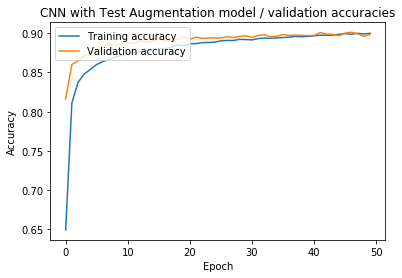

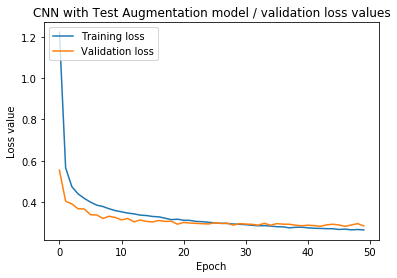

In [11]:
plt.plot(CNNHistory2.history['accuracy'], label='Training accuracy')
plt.plot(CNNHistory2.history['val_accuracy'], label='Validation accuracy')
plt.title('CNN with Test Augmentation model / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(CNNHistory2.history['loss'], label='Training loss')
plt.plot(CNNHistory2.history['val_loss'], label='Validation loss')
plt.title('CNN with Test Augmentation model / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [12]:
CNN_model3 = conv_model()

In [13]:
%%time

#Aug Train & Aug Test

CNNHistory3 = CNN_model3.fit(img_gen.flow(X_trainCNN,y_trainCNN), validation_data=(X_testCNN, y_testCNN), batch_size=200,epochs=50, verbose=2)
CNN_scores3 = CNN_model3.evaluate(img_gen.flow(X_testCNN, y_testCNN), verbose=0)

print("Baseline Error: %.2f%%" % (100-CNN_scores3[1]*100))
print(f'Test loss for base CNN: {CNN_scores3[0]} / Test accuracy: {CNN_scores3[1]}')

Epoch 1/50
3525/3525 - 83s - loss: 1.6245 - accuracy: 0.5288 - val_loss: 0.6297 - val_accuracy: 0.7872
Epoch 2/50
3525/3525 - 82s - loss: 0.8954 - accuracy: 0.7124 - val_loss: 0.4570 - val_accuracy: 0.8440
Epoch 3/50
3525/3525 - 83s - loss: 0.7800 - accuracy: 0.7435 - val_loss: 0.4713 - val_accuracy: 0.8383
Epoch 4/50
3525/3525 - 81s - loss: 0.7240 - accuracy: 0.7608 - val_loss: 0.4415 - val_accuracy: 0.8465
Epoch 5/50
3525/3525 - 82s - loss: 0.6841 - accuracy: 0.7735 - val_loss: 0.4124 - val_accuracy: 0.8524
Epoch 6/50
3525/3525 - 82s - loss: 0.6576 - accuracy: 0.7798 - val_loss: 0.3920 - val_accuracy: 0.8633
Epoch 7/50
3525/3525 - 81s - loss: 0.6333 - accuracy: 0.7877 - val_loss: 0.3972 - val_accuracy: 0.8612
Epoch 8/50
3525/3525 - 81s - loss: 0.6192 - accuracy: 0.7928 - val_loss: 0.3788 - val_accuracy: 0.8682
Epoch 9/50
3525/3525 - 82s - loss: 0.6027 - accuracy: 0.7978 - val_loss: 0.3891 - val_accuracy: 0.8626
Epoch 10/50
3525/3525 - 82s - loss: 0.5917 - accuracy: 0.8016 - val_loss:

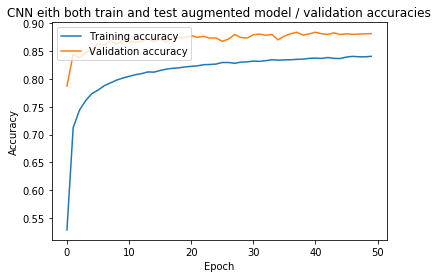

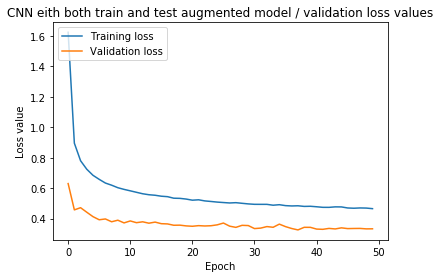

In [14]:
plt.plot(CNNHistory3.history['accuracy'], label='Training accuracy')
plt.plot(CNNHistory3.history['val_accuracy'], label='Validation accuracy')
plt.title('CNN eith both train and test augmented model / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(CNNHistory3.history['loss'], label='Training loss')
plt.plot(CNNHistory3.history['val_loss'], label='Validation loss')
plt.title('CNN eith both train and test augmented model / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()